<img src="../logo_UTN.svg" align="right" width="200" /> 

# Tarea semanal 7
## Manuel Dieguez

# ¿Que vamos a estudiar en esta tarea?

Cuando tomamos una o varias muestras de una senal, como por ejemplo en un electrocardiograma, podemos observar que el espectro de cada muestra es diferente, esto es asi ya que la FFT funciona como un estimador. Vamos a comparar resultados de diferentes estimadores vistos en la teoria.

Para esto, vamos a trabajar con la potencia espectral como estimador, para finalmente, tratar de estimar el Ancho de banda de la senal medida

Vamos a utilizar una senal de audio para esto

In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from bartlett_periodogram import *
import scipy.io as sio
from scipy.io.wavfile import write

In [3]:
def bartlett_periodogram(x, fs, segment_size):
    """
    Calcula el periodograma de Bartlett para una señal x.

    Parámetros:
    - x: Señal de entrada (1D)
    - fs: Frecuencia de muestreo
    - segment_size: Tamaño de cada segmento
    
    Retorna:
    - f: Vector de frecuencias
    - Pxx: PSD estimada
    """
    # Número de segmentos
    num_segments = len(x) // segment_size

    # Inicializamos el acumulador de PSD
    Pxx = np.zeros(segment_size)

    # Calculamos el periodograma para cada segmento
    for i in range(num_segments):
        segment = x[i * segment_size:(i + 1) * segment_size]
        X = np.fft.fft(segment)  # FFT del segmento
        Pxx_segment = (np.abs(X[:segment_size]) ** 2) / segment_size  # PSD del segmento
        Pxx += Pxx_segment  # Acumulamos la PSD

    # Promediamos la PSD sobre los segmentos
    Pxx /= num_segments

    # Frecuencias correspondientes
    f = np.fft.fftfreq(segment_size, d=1/fs)[:segment_size]

    return f, Pxx

Primero vamos a extraer la senal y realizar un periodograma para estimar la potencia espectral


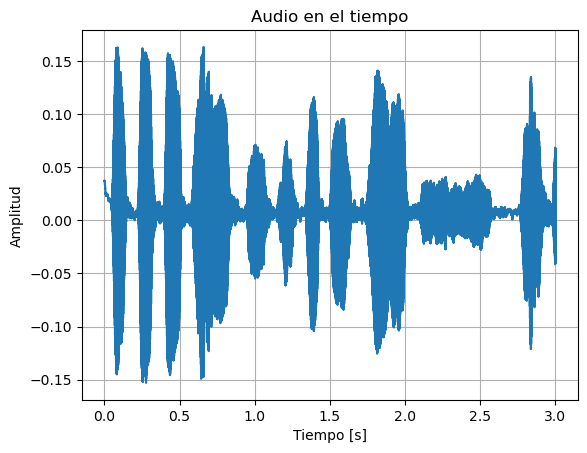

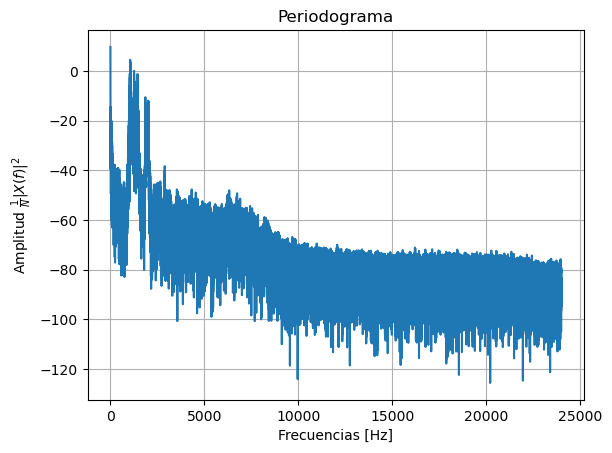

In [4]:
## Extraemos la senal de audio del archivo

fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')

## Realicemos un periodogrma de la senal

N = len(wav_data)
freqs = np.fft.fftfreq(N,d= 1/fs_audio)

t = np.linspace(0, N/fs_audio, N )
plt.figure(1)
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.title("Audio en el tiempo")
plt.plot(t,wav_data)
plt.grid()
plt.show()

fft_audio = np.fft.fft(wav_data)
per_audio = np.abs(fft_audio)**2/N

plt.figure(2)
plt.title("Periodograma")
plt.xlabel("Frecuencias [Hz]")
plt.ylabel(r"Amplitud $ \frac{1}{N} |X(f)|^{2} $")  ## Revisar LaTex
plt.plot(freqs[:N//2],10*np.log10(per_audio[:N//2]))
plt.grid()
plt.show()


Ahora vamos a agregar un ventaneo a la senal, usando una ventana de Blackman

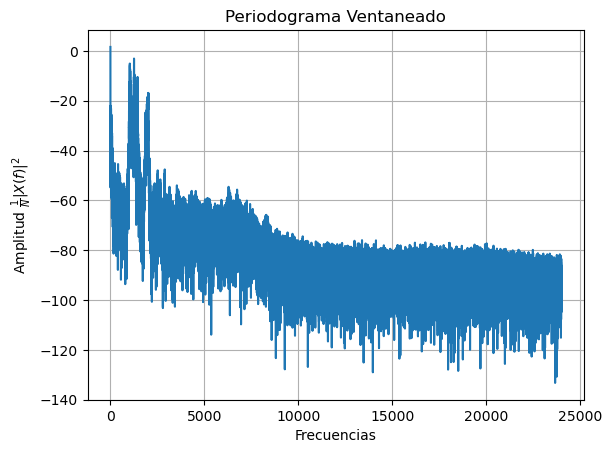

In [5]:
## Procedemos a realizar un Periodograma ventaneado

window_blackman = np.blackman(N)
fft_audio_per_vent = np.fft.fft(wav_data*window_blackman)
per_vent_audio = np.abs(fft_audio_per_vent)**2/N

plt.figure(3)
plt.title("Periodograma Ventaneado")
plt.xlabel("Frecuencias")
plt.ylabel(r"Amplitud $\frac{1}{N}|X(f)|^{2}$")  ## Revisar LaTex
plt.plot(freqs[:N//2],10*np.log10(per_vent_audio[:N//2]))
plt.grid()
plt.show()

Ahora, vamos a realizar una estimacion por metodo de Bartlett, que consiste en subdivir la muestra en varios segmentos, calcular el periodograma de cada uno y promediar

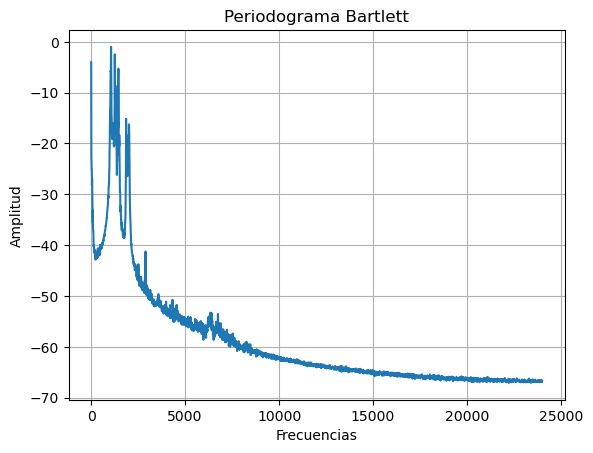

In [6]:
## Metodo de Bartlett

segment_size = int(N/24)
[freqs_bartlett, fft_bartlett] = bartlett_periodogram(wav_data, fs_audio, segment_size)
N_bartlett = len(freqs_bartlett)

plt.figure(4)
plt.title("Periodograma Bartlett")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_bartlett[:N_bartlett//2],10*np.log10(fft_bartlett[:N_bartlett//2]))
plt.grid()
plt.show()

Podemos ver como se reduce  la varianza en cada frecuencia, viendo ese suavizado en la FFT. Hay que ser consciente de que este metodo empeora la resolucion, tienendo que elegir entre varianza y resolucion

Por ultimo, vamos a utilizar el metodo de Welch. El mismo requiere armar diferentes bloques a partir de una muestra, las mismas pueden estar solapadas ya que se pueden considerar  de diferentes muestras si el proceso es estacionario en sentido amplio. A su vez, cada muestra se ventanea, lo que ayuda a reducir el sesgo

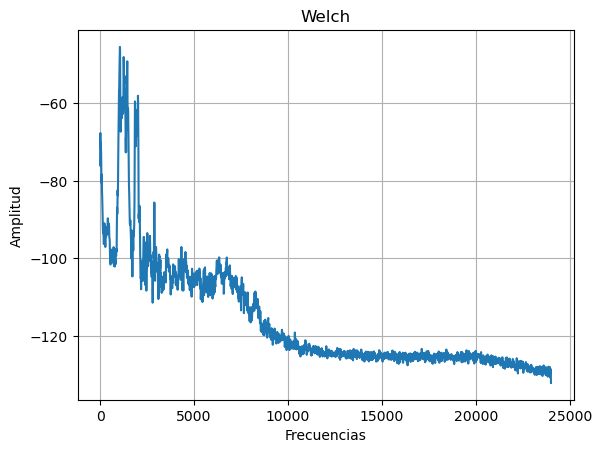

In [7]:
w=24  ## Numero de ventanas 
[freqs_welch, fft_welch] = sc.signal.welch(wav_data, fs_audio, window = "hann", nperseg = int(N/w))

plt.figure(5)
plt.title("Welch")
plt.xlabel("Frecuencias")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(freqs_welch,10*np.log10(fft_welch))
plt.grid()
plt.show()

 ## Calculo del ancho de banda

 Vamos a buscar estimar el ancho de banda de la senal, tomando cierto porcentaje de la potencia de la senal a partir de nuestra estimacion de potencia

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


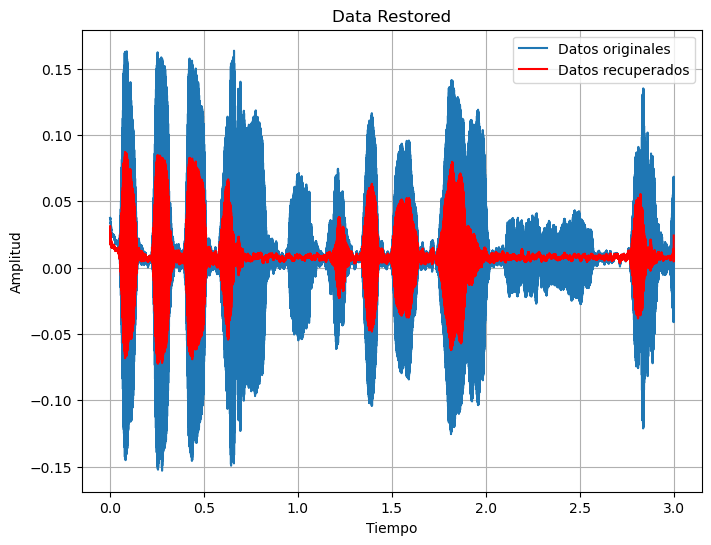

In [12]:
## Tomamos el BW a partir de Welch

BW_total_pow = 0.7
sumatoria = 0

per_norm = fft_welch/np.sum(np.abs(fft_welch))

for i in range(0,len(fft_welch)):
    sumatoria += np.abs(per_norm[i])
    index_bw = i
    if sumatoria >= BW_total_pow:
        break

BW = freqs_welch[i]
fft_filter = np.zeros_like(fft_audio)
fft_filter[:index_bw*w] = fft_audio[:w*index_bw] ## w para reajustar lo que se achico el indice en welch

wav_data_restored =np.fft.ifft(fft_filter)       ## No es el mejor porque transformo el brickwall

plt.figure(6, figsize=(8,6))
plt.title("Data Restored")
plt.xlabel("Tiempo")
plt.ylabel(f"Amplitud")  ## Revisar LaTex
plt.plot(t, wav_data,label = "Datos originales")
plt.plot(t,wav_data_restored, color = "red", label = "Datos recuperados")
plt.legend()
plt.grid()
plt.show()